# Credit Score Simulator with finite samples

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

#### Experimental setup arguments

In [2]:
# Experimental setup arguments

class args:

    # softness parameter for the sigmoid approximating the indicator function, 1 = original, inf = indicator
    loss_softness = 10
    utility_softness = 10

    # risk control parameter
    alpha = 0.2

    # risk control probability (delta_prime)
    delta = 0.25

    # epsilon
    epsilon = 1


## Data, strategic features, and model

Import data. Last column of X is a constant.

In [ ]:
from data_prep import load_data

path_to_csv_file = './data/cs-training.csv'
X_all, Y_all, data = load_data(path_to_csv_file)

n = X_all.shape[0]
d = X_all.shape[1] - 1

print('n=',n)
print('d=',d)

size = n // 3
X_train, X_cv, Y_train, Y_cv = train_test_split(X_all, Y_all, train_size=size, random_state=42)
del X_all, Y_all

n= 18357
d= 10


Define strategic features

In [51]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


Create pretrained classifier: $f_{\theta}$. Train a logistic regression model on train data. Use the rest for calibration and validation.

In [71]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

In [72]:
model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)

[[ 0.06908175 -0.36900597  1.91063774 -0.06958826 -0.40016831  0.00388092
   1.92199988  0.10833517  0.52384618  0.0820659  -0.37902675]]


In [74]:
# No regularization: no significant difference
model_no_reg = train_logistic_regression(X_train, Y_train, penalty=None)
print(model_no_reg.coef_)
del model_no_reg

[[ 0.06954804 -0.36929598  1.93433609 -0.07003653 -0.40371777  0.00500597
   1.96983278  0.10918351  0.52019011  0.08191798 -0.37965715]]


In [ ]:
import pandas as pd
pd.DataFrame({
    # 'index': range(d+1),
    'feature': np.concatenate((data.columns[1:], ['bias'])),  # replace label w/ const
    'strategic': ['yes' if i in strat_features else 'no' for i in range(d+1)],
    'model_coef': model.coef_[0]
})

,feature,strategic,model_coef
0,RevolvingUtilizationOfUnsecuredLines,yes,0.069082
1,age,no,-0.369006
2,NumberOfTime30-59DaysPastDueNotWorse,no,1.910638
3,DebtRatio,no,-0.069588
4,MonthlyIncome,no,-0.400168
5,NumberOfOpenCreditLinesAndLoans,yes,0.003881
6,NumberOfTimes90DaysLate,no,1.922000
7,NumberRealEstateLoansOrLines,yes,0.108335
8,NumberOfTime60-89DaysPastDueNotWorse,no,0.523846
9,NumberOfDependents,no,0.082066


In [85]:
model.coef_[0][strat_features]

array([0.06908175, 0.00388092, 0.10833517])

Define utility functions

In [154]:
# f(theta^T x)
# Utility: u(x, lambda) = softmax(gamma * (1 - lambda  - f(theta^T x)  ))
from typing import Union


def sigmoid(X):
    return 1 / (1 + np.exp(-X))


def type_II_error(Y, Y_pred):
    return np.mean((Y == 1) & (Y_pred == 0))


class SoftLoss:
    """Soft-cutoff loss function (assumption 1)."""
    def __init__(self, softness):
        self.softness = softness

    def __call__(self, Y, Y_prob, threshold):
        """Evaluates y_true * sigmoid(softness * (1 - threshold - Y_prob))"""
        return np.mean(Y * sigmoid(self.softness * (1 - threshold - Y_prob)))
    

class ThreshUpdater:
    """Abstract class for threshold update."""
    def get_thresh_predeploy(self, Y_cal, Y_cal_proba):
        raise NotImplementedError

    def update_postdeploy(self, loss_violation: bool):
        return


class SoftLossThreshUpdater(ThreshUpdater):
    """Threshold update based on soft loss."""

    def __init__(self, soft_loss: SoftLoss, delta: float,
                 thresh_lower_bound=0, thresh_upper_bound=1):
        self.soft_loss = soft_loss
        self.delta = delta
        self.thresh_lower_bound = thresh_lower_bound
        self.thresh_upper_bound = thresh_upper_bound

    def get_thresh_predeploy(self, Y_cal, Y_cal_proba, error_bound=1e-6):
        """Updates the threshold. Assumes constant n throughout time.
        """
        n = len(Y_cal)
        bound = args.alpha - np.sqrt((1. / 2 / n) * np.log(1 / self.delta))

        partial_loss = lambda threshold: self.soft_loss(Y_cal, Y_cal_proba, threshold)

        # determine min threshold at which risk is controlled
        low, high = self.thresh_lower_bound, self.thresh_upper_bound
        while high - low > error_bound:
            mid = (low + high) / 2
            if partial_loss(mid) > bound:
                low = mid
            else:
                high = mid
        return (low + high) / 2


class BinaryThreshUpdater(ThreshUpdater):
    
    def __init__(self, thresh_lower_bound, thresh_upper_bound):
        self.thresh_lower_bound = thresh_lower_bound
        self.thresh_upper_bound = thresh_upper_bound
    
    def get_thresh_predeploy(self, Y_cal, Y_cal_proba):
        return (self.thresh_lower_bound + self.thresh_upper_bound) / 2

    def update_postdeploy(self, loss_violation: bool):
        mid = (self.thresh_lower_bound + self.thresh_upper_bound) / 2
        if loss_violation:
            self.thresh_lower_bound = mid
        else:
            self.thresh_upper_bound = mid


class FeaturesUpdater:
    """Abstract class for updating features based on model and strategic features."""
    def __init__(self, model: LogisticRegression, strat_features: Union[np.ndarray, None], eps: float):
        self.model_params = model.coef_[0]
        if strat_features is not None:
            self.strat_coef = np.zeros((1, d+1))
            self.strat_coef[0, strat_features] = model.coef_[0, strat_features]
        else:
            self.strat_coef = model.coef_[0]
        self.eps = eps

    def best_response(self, X, Y_proba, thresh):
        raise NotImplementedError


class SoftUtilityFeaturesUpdater(FeaturesUpdater):
    """Models the distribution shift of the features. Assumes access to model.
    
    Assumes a sigmoidal utility function (scaled + stretched) and a quadratic cost."""

    def __init__(self, model: LogisticRegression, strat_features: np.ndarray, eps: float, utility_softness: float):
        super().__init__(model, strat_features, eps)
        self.utility_softness = utility_softness

    def _get_C_gamma(self, gamma):
        """Find the largest abs value of the second derivative of the scaled sigmoid"""
        from scipy.optimize import minimize_scalar

        def second_deriv_scaled_sigmoid(x, gamma):
            return 2*(gamma**2)*np.exp(-2* gamma*x) / (np.exp(-gamma*x)+1)**3 \
                - (gamma**2)*np.exp(-gamma*x) / (np.exp(-gamma*x)+1)**2

        # function is odd and negative on [0, 100]
        result = minimize_scalar(lambda x: second_deriv_scaled_sigmoid(x, gamma), bounds=(0, 100), method='bounded')

        if result.x < 1e-5 or result.x > 100 - 1e-5:
            raise ValueError('gamma minimization outside of range')

        return -second_deriv_scaled_sigmoid(result.x, gamma).item()

    def _calc_g_eps(self):
        """Compute quadratic cost coefficient based on desired level of epsilon-sensitivity."""
        return 4 * self.eps / self.utility_softness / np.linalg.norm(self.strat_coef).item() \
            / self._get_C_gamma(self.utility_softness)

    def best_response(self, X, Y_proba, thresh):
        """Best response function for agents, linear utilities quadratic costs

        # Assume very utility function is soft threshold
        # Calculate the best response by computing the derivative of 
        # the utility minus the cost
        """
        # apply chain rule
        soft_indicator_deriv = sigmoid(self.utility_softness * (1 - thresh - Y_proba))
        soft_indicator_deriv *= (1 - soft_indicator_deriv)  # soft indicator fn

        proba_deriv = - self.utility_softness * Y_proba * (1 - Y_proba)  # predictor

        deriv_scale = (soft_indicator_deriv * proba_deriv).reshape(-1, 1)  # based on threshold

        X_strat = X + self._calc_g_eps() * deriv_scale * self.strat_coef
        # X_strat = X + self.eps * deriv_scale * strat_coef
        # X_strat = X + self.eps * strat_coef
        # print("Ratio eps / g(eps): ", self.eps / self._calc_g_eps())

        return X_strat


class NoCostFeaturesUpdater(FeaturesUpdater):
    """Update the most sensitive feature."""

    def __init__(self, model: LogisticRegression, strat_features: Union[np.ndarray,None], eps: float):
        super().__init__(model, strat_features, eps)

        sensitive_idx = self.strat_coef[0].argmax()
        self.onehot = np.zeros((1, d+1))
        self.onehot[0, sensitive_idx] = 1

    def best_response(self, X, Y_proba, thresh):
        X_start = X + self.eps * thresh * self.onehot
        return X_start

In [155]:
from sklearn.metrics import accuracy_score

Y_proba = model.predict_proba(X_train)[:,1]
Y_pred = Y_proba > 0.5

example_thresh = 0.5
print(f" ----- example_thresh = {example_thresh} -----")
for softness in [1, 2, 4, 7, 10, 20, 40, 70, 100, 1000]:
    soft_loss = SoftLoss(softness)
    print(f"Soft loss @ softness = {softness}: ", soft_loss(Y_train, Y_proba, example_thresh))

print("Train accuracy: ", accuracy_score(Y_train, Y_pred))
print("Type II error: ", type_II_error(Y_train, Y_pred))

 ----- example_thresh = 0.5 -----
Soft loss @ softness = 1:  0.21974638402526167
Soft loss @ softness = 2:  0.21322064892859882
Soft loss @ softness = 4:  0.20359338124381987
Soft loss @ softness = 7:  0.1973968410888181
Soft loss @ softness = 10:  0.19664557498693147
Soft loss @ softness = 20:  0.20121457259255307
Soft loss @ softness = 40:  0.2066748211165832
Soft loss @ softness = 70:  0.20947450512088572
Soft loss @ softness = 100:  0.21057158236888482
Soft loss @ softness = 1000:  0.21256045848413094
Train accuracy:  0.7269161627716947
Type II error:  0.21277986599117502


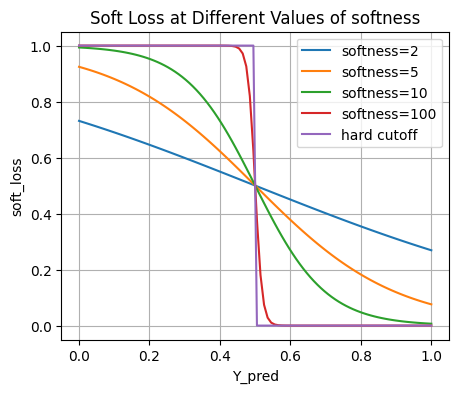

In [156]:
threshold = 0.5
Y_proba_sample = np.linspace(0, 1, 100)

plt.figure(figsize=(5,4))
for softness in [2, 5, 10, 100]:
    plt.plot(Y_proba_sample, sigmoid(softness * (1 - threshold - Y_proba_sample)), label=f'softness={softness}')
# indicator
plt.plot(Y_proba_sample, (Y_proba_sample <= threshold).astype(int), label='hard cutoff')

plt.xlabel('Y_pred')
plt.ylabel('soft_loss')
plt.title('Soft Loss at Different Values of softness')
plt.legend()
plt.grid(True)
plt.show()

## Simulations

#### Risk Control Under Performativity

- Distributional changes under algorithm: store histograms


- Visualize distribution changes under algorithm
- Compare to binary search
    - empirical loss through iterations
    - soft loss / hard loss on threshold throughout iterations
- Experiment w/ different epsilon's, softness

In [157]:
class Logger:
    def __init__(self):
        self.data = {}

    def update(self, step, values):
        for key, value in values.items():
            if key not in self.data:
                self.data[key] = {}
            self.data[key][step] = value

    def get_data(self, key):
        sorted_data = sorted(self.data[key].items())
        return zip(*sorted_data)  # steps, values

Main runner

In [160]:
def run_iters(soft_loss: SoftLoss, thresh_updater: ThreshUpdater, features_updater: FeaturesUpdater,
              model: LogisticRegression, X_cv, Y_cv, args, random_state=42, cal_size=3000,
              total_iter=20, thresh_init=1.):
    """
    model: pretrained logistic regression
    X, Y: data
    total_iter: number of steps
    random_state: random seed for splitting data
    method: 'ubc' or 'bin_search'
    """

    thresh = thresh_init

    logger = Logger()

    # calibration/validation split
    X_cal, X_val, Y_cal, Y_val = train_test_split(X_cv, Y_cv, train_size=cal_size, random_state=random_state)
    # Get initial histogram
    Y_val_proba = model.predict_proba(X_val)[:,1]
    Y_cal_proba = model.predict_proba(X_cal)[:,1]
    logger.update(0,
                  {
                      "Y_cal_proba": Y_cal_proba, "Y_val_proba": Y_val_proba,
                      "Y_cal": Y_cal, "Y_val": Y_val,
                      "thresh": thresh
                  })

    for iter in range(total_iter):

        # Deploy threshold of time t and get data of time t
        X_val_iter = features_updater.best_response(X_val, Y_val_proba, thresh)
        X_cal_iter = features_updater.best_response(X_cal, Y_cal_proba, thresh)
        Y_val_proba_iter = model.predict_proba(X_val_iter)[:,1]
        Y_cal_proba_iter = model.predict_proba(X_cal_iter)[:,1]

        # Update threshold t -> t+1
        thresh_new = thresh_updater.get_thresh_predeploy(Y_cal, Y_cal_proba_iter)

        # Evaluate to get empirical risk on cal set and a proxy for population risk (using updated thresh)
        # Assume ground truth doesn't change
        loss_val = soft_loss(Y_val, Y_val_proba_iter, thresh_new)
        loss_cal = soft_loss(Y_cal, Y_cal_proba_iter, thresh_new)
        type_II_error_val = type_II_error(Y_val, Y_val_proba_iter > thresh_new)
        type_II_error_cal = type_II_error(Y_cal, Y_cal_proba_iter > thresh_new)

        thresh_updater.update_postdeploy(loss_cal > args.alpha)
        thresh = thresh_new

        # Log
        logger.update(iter+1,
                      {"loss_val": loss_val, "loss_cal": loss_cal,
                      "type_II_error_val": type_II_error_val, "type_II_error_cal": type_II_error_cal,
                      "Y_cal_proba": Y_cal_proba_iter, "Y_val_proba": Y_val_proba_iter, "Y_cal": Y_cal, "Y_val": Y_val,
                      "thresh": thresh})

    return logger

Viz code

In [183]:
_, x = results.get_data('thresh')
x

(1.0,
 0.5102982521057129,
 0.515836238861084,
 0.5158486366271973,
 0.5158486366271973,
 0.5158486366271973)

In [190]:
def plot_histogram_evolution(logger, ax, title, bounds=0.05):

    _, Y_cal_proba = logger.get_data("Y_cal_proba")
    _, thresh_all = logger.get_data("thresh")
    # _, Y_cal = logger.get_data("Y_cal")

    # plot around the last threshold
    last_thresh = thresh_all[-1]

    window_low, window_high = last_thresh - bounds, last_thresh + bounds
    # Y_cal_proba = [Y_cal_proba_iter[(Y_cal_proba_iter >= window_low) & (Y_cal_proba_iter <= window_high)]
    #                  for Y_cal_proba_iter in Y_cal_proba]
    
    Y_cal_hist = [np.histogram(Y_cal_proba_iter, np.linspace(window_low, window_high, 101))[0] 
                  for Y_cal_proba_iter in Y_cal_proba]    

    hist_data = np.array(Y_cal_hist)

    # Plot heatmap
    ax.imshow(hist_data.T, aspect='auto', cmap='viridis', origin='lower')
    ax.plot(range(len(thresh_all)),
            (100 * (1 - np.array(thresh_all)) - 100 * window_low) / (100 * (window_high - window_low)),
            color='red', linestyle="--", linewidth=2, label=r'1-$\lambda$')

    yticks = np.linspace(0, 100, 11)  # Tick positions on the 0-100 scale
    yticklabels = [f"{y/100:.1f}" for y in yticks]  # Format tick labels to 2 decimal places
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    ax.set_title(title)
    ax.set_xlabel('iteration')
    ax.set_ylabel('predicted default probability')
    ax.legend()


def print_thresh(logger, **kwargs):
    _, thresh_all = logger.get_data("thresh")
    string_kwargs = ", ".join([f"{key}={value}" for key, value in kwargs.items()])
    print(f"Thresholds ({string_kwargs}): ", end="")
    for thresh in thresh_all:
        print(f"{thresh:.4f}", end=", ")
    print()


def show_loss_over_iter(logger, alpha, delta, n=5000):
    """
    alpha: risk control level
    delta: risk conrol probability (1 - delta = probability)
    """

    steps, loss_cal = logger.get_data("loss_cal")
    _, loss_val = logger.get_data("loss_val")
    _, type_II_error_cal = logger.get_data("type_II_error_cal")
    _, type_II_error_val = logger.get_data("type_II_error_val")

    plt.figure(figsize=(5, 4))
    plt.rcParams['text.usetex'] = False

    # Risk to control
    plt.axhline(alpha, color='r', linestyle='--', label=r'$\alpha$')

    hoeff_risk = alpha - np.sqrt((1. / 2 / n) * np.log(1 / delta))
    plt.axhline(hoeff_risk, color='gray', linestyle='--', label="ucb bound")

    plt.plot(steps, loss_cal, label='calibration soft loss', color='b')
    plt.plot(steps, loss_val, label='validation soft loss', color='g')
    # plt.plot(steps, type_II_error_cal, label='calibration hard loss', color='b', linestyle='--')
    # plt.plot(steps, type_II_error_val, label='validation hard loss', color='g', linestyle='--')

    plt.xlabel('Steps')
    plt.ylabel('Soft Loss')
    plt.title(rf'Soft Loss over Iterations ($\alpha={alpha}$, $\delta={delta}$)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [283]:
def plot_histogram_evolution(logger, title='histogram evolution', plot_range=0.05):
    import seaborn as sns

    steps, Y_cal_proba = logger.get_data("Y_cal_proba")
    _, thresh_all = logger.get_data("thresh")
    # _, Y_cal = logger.get_data("Y_cal")

    # plot around the last threshold
    last_thresh = thresh_all[-1]

    plot_range = max(plot_range, np.abs(np.array(thresh_all[1:]) - last_thresh).max() + 0.01)

    window_low, window_high = (1 - last_thresh) - plot_range, (1 - last_thresh) + plot_range

    # Create subplots
    fig, axes = plt.subplots(1, len(thresh_all), figsize=(12, 4), sharex=True, sharey=True)

    # Flatten axes array for easy indexing
    axes = axes.flatten()

    # Plot each distribution in its own subplot
    for i, t in enumerate(steps):
        ax = axes[i]
        sns.kdeplot(y=Y_cal_proba[t], ax=ax, fill=True, bw_adjust=0.01, alpha=0.7, color='skyblue')
        
        if i == 0:
            ax.set_ylabel('predicted default probability')  # Set label for the first subplot
            ax.spines['left'].set_visible(True)  # Show the left spine
            ax.tick_params(axis='y', which='both', length=4)  # Show ticks on the y-axis
        else:
            ax.spines['left'].set_visible(False)  # Hide the left spine for other plots
            ax.tick_params(axis='y', left=False)  # Remove y-axis ticks
            # ax.set_yticks([])  # Remove y-axis labels

        ax.spines['top'].set_visible(False)  # Remove top spine
        ax.spines['right'].set_visible(False)  # Remove right spine
        ax.spines['bottom'].set_visible(False)  # Remove bottom spine
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_xlabel(None)
        ax.set_title(f't={t}')  # Set title with time step
        ax.set_ylim(window_low, window_high)  # Set y-axis limits

        ax.axhline(y=1 - thresh_all[t], color='red', linestyle='--')  # Add horizontal line for threshold

    # Add a global title and adjust layout
    fig.suptitle('histogram evolution', fontsize=16, y=0.95)
    fig.tight_layout()
    fig.show()


threshold trajectory:  (1.0, 0.5135083198547363, 0.5686192512512207, 0.5672087669372559, 0.5673098564147949, 0.5673022270202637)


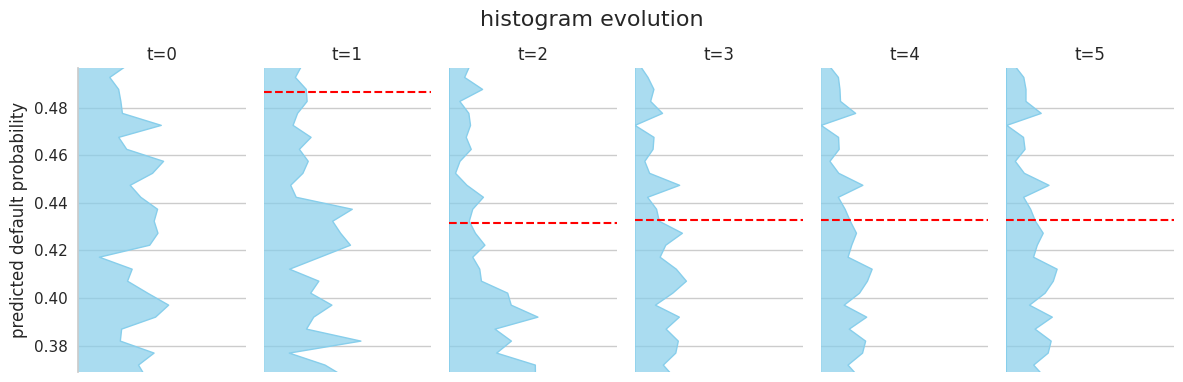

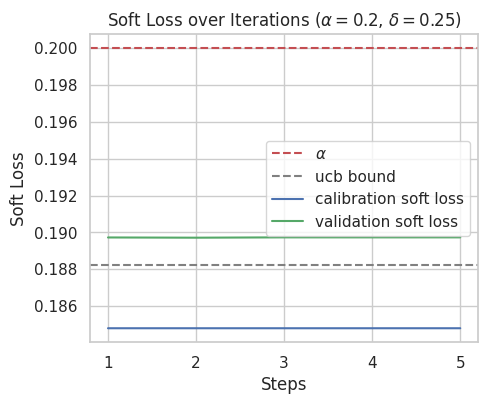

In [285]:
args.epsilon = 100

random_state = 124
soft_loss = SoftLoss(args.loss_softness)
thresh_updater = SoftLossThreshUpdater(soft_loss, args.delta)
features_updater = SoftUtilityFeaturesUpdater(model, strat_features, args.epsilon, utility_softness=args.utility_softness)
results = run_iters(soft_loss, thresh_updater, features_updater, model,
                    X_cv, Y_cv, args, random_state=random_state, total_iter=5)

steps, Y_cal_proba = results.get_data("Y_cal_proba")
_, Y_cal = results.get_data("Y_cal")
_, threshs = results.get_data("thresh")
print("threshold trajectory: ", threshs)

plot_histogram_evolution(results, title='histogram evolution')
show_loss_over_iter(results, args.alpha, args.delta)

threshold trajectory:  (1.0, 0.48475122451782227, 0.49772119522094727, 0.4973940849304199, 0.4974026679992676, 0.49740171432495117)


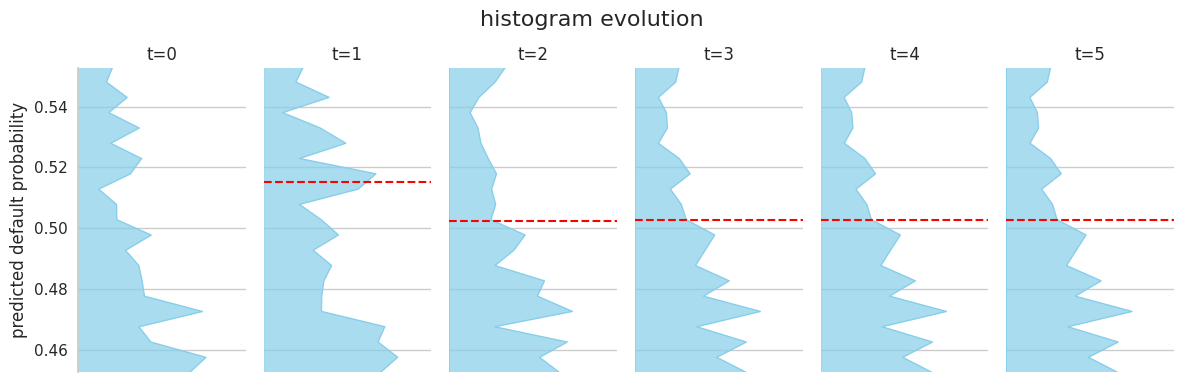

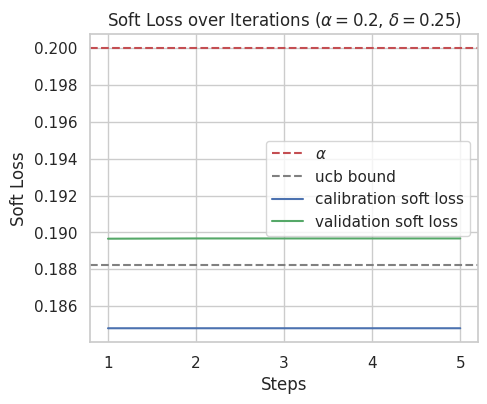

In [286]:
# binary
args.epsilon = 1

random_state = 124
soft_loss = SoftLoss(args.loss_softness)
thresh_updater = SoftLossThreshUpdater(soft_loss, args.delta)
features_updater = NoCostFeaturesUpdater(model, strat_features, args.epsilon)
results = run_iters(soft_loss, thresh_updater, features_updater, model,
                    X_cv, Y_cv, args, random_state=random_state, total_iter=5)

steps, Y_cal_proba = results.get_data("Y_cal_proba")
_, Y_cal = results.get_data("Y_cal")
_, threshs = results.get_data("thresh")
print("threshold trajectory: ", threshs)

plot_histogram_evolution(results, title='histogram evolution')
show_loss_over_iter(results, args.alpha, args.delta)

In [280]:
args.loss_softness, args.utility_softness

(10, 10)

threshold trajectory:  (1.0, 0.5, 0.25, 0.375, 0.4375, 0.46875)
0.3025 0.76


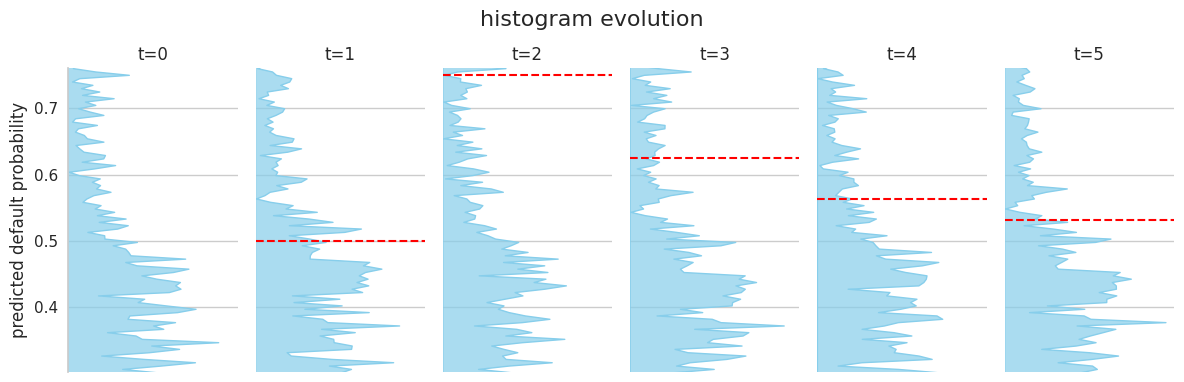

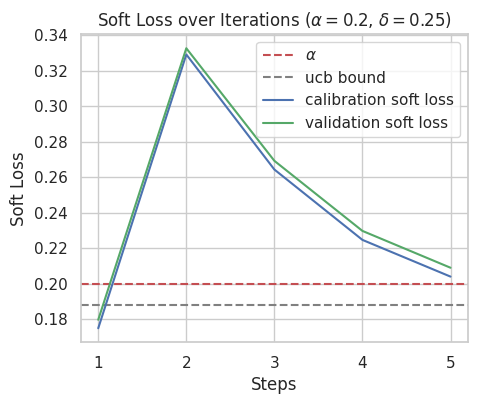

In [281]:
# binary
args.epsilon = 1

random_state = 124
soft_loss = SoftLoss(args.loss_softness)
thresh_updater = BinaryThreshUpdater(0, 1)
features_updater = NoCostFeaturesUpdater(model, strat_features, args.epsilon)
results = run_iters(soft_loss, thresh_updater, features_updater, model,
                    X_cv, Y_cv, args, random_state=random_state, total_iter=5)

steps, Y_cal_proba = results.get_data("Y_cal_proba")
_, Y_cal = results.get_data("Y_cal")
_, threshs = results.get_data("thresh")
print("threshold trajectory: ", threshs)

plot_histogram_evolution(results, title='histogram evolution')
show_loss_over_iter(results, args.alpha, args.delta)

In [87]:
# algorithm aproach

# 2 important parameters: epsilon and utility softness

# If utility softness is too low, the utility function becomes "linear". This diminishes the effect
# of different lambdas on the distribution shift. This means after one-two iterations, the threshold
# converges.

# If the utility softness is higher, then epsilon needs to be larger b/c the utility function's
# derivatives are smaller. Too large epsilon (eps > 1) is not guaranteed by the theory.

def show_eps_plots(epsilons, utility_softness):

    fig, axs = plt.subplots(2, 3, figsize=(8, 6))

    for idx, epsilon in enumerate(epsilons):
        args.utility_softness = utility_softness
        args.epsilon = epsilon
        logger = run_iters(model, X_cv, Y_cv, args, total_iter=5, random_state=42, cal_size=3000)
        print_thresh(logger, epsilon=epsilon, utility_softness=args.utility_softness)

        fig.suptitle(r'$f_{\theta}(x)$ histogram evolution ($\gamma=$' + f"{args.utility_softness})")
        i, j = idx // 3, idx % 3
        plot_histogram_evolution(logger, axs, i, j, title=r'$\epsilon=$' + str(epsilon))
    plt.tight_layout()
    plt.show()
    

In [ ]:
epsilons = np.array([1e-2, 1e-1, 2e-1, 5e-1, 8e-1, 1, 100]) * 100
show_eps_plots(epsilons, utility_softness=10)

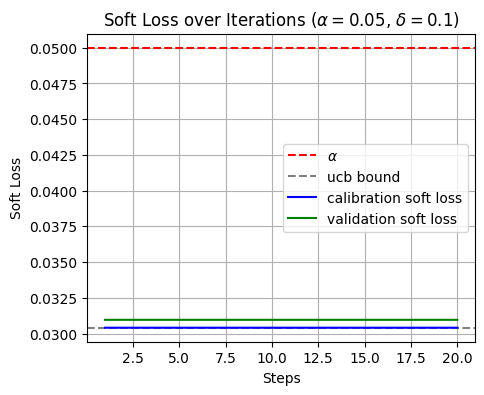

In [ ]:
show_loss_over_iter(logger, args.alpha, args.delta, n=3000)

#### Binary search

Thresholds: 1.0000, 0.5000, 0.7500, 0.8750, 0.8125, 0.7812, 0.7656, 0.7734, 0.7695, 0.7676, 0.7686, 0.7690, 0.7693, 0.7692, 0.7692, 0.7692, 0.7692, 0.7692, 0.7692, 0.7692, 0.7692, 

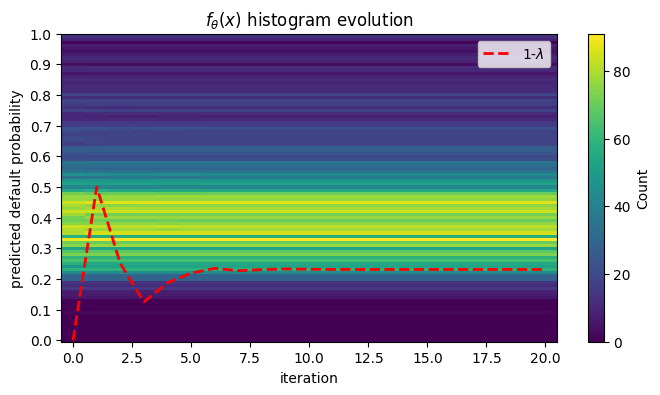

In [53]:
# Run over different seeds
# Run over binary search

bin_search_logger = run_iters(model, X_cv, Y_cv, args, total_iter=20, random_state=42, cal_size=3000, method='bin_search')
print_thresh(bin_search_logger)
plot_histogram_evolution(bin_search_logger)

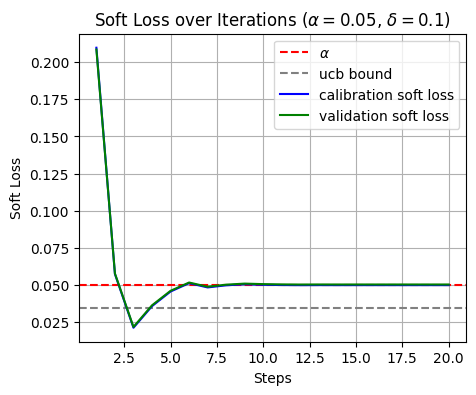

In [54]:
show_loss_over_iter(bin_search_logger, args.alpha, args.delta)

#### Confidence Bounds

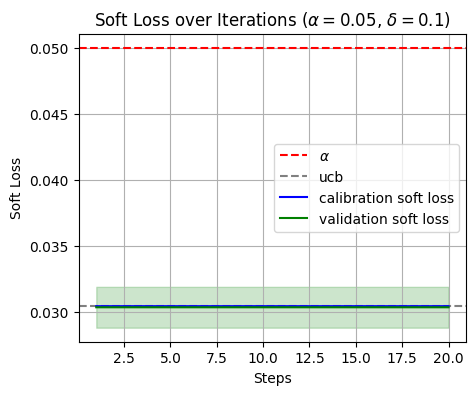

In [57]:
alpha = args.alpha
delta = args.delta
n = 3000


loggers = [
    run_iters(model, X_cv, Y_cv, args, total_iter=20, random_state=i, method='ucb') for i in range(100)
]

plt.figure(figsize=(5, 4))
plt.rcParams['text.usetex'] = False


loss_cals, loss_vals, type_II_error_cals, type_II_error_vals = [], [], [], []

for logger in loggers:
    steps, loss_cal = logger.get_data("loss_cal")
    _, loss_val = logger.get_data("loss_val")
    _, type_II_error_cal = logger.get_data("type_II_error_cal")
    _, type_II_error_val = logger.get_data("type_II_error_val")
    loss_cals.append(loss_cal)
    loss_vals.append(loss_val)
    type_II_error_cals.append(type_II_error_cal)
    type_II_error_vals.append(type_II_error_val)

# Collapse to find mean and std
loss_cals_mean = np.mean(loss_cals, axis=0)
loss_vals_mean = np.mean(loss_vals, axis=0)
type_II_error_cals_mean = np.mean(type_II_error_cals, axis=0)
type_II_error_vals_mean = np.mean(type_II_error_vals, axis=0)

loss_cals_std = np.std(loss_cals, axis=0)
loss_vals_std = np.std(loss_vals, axis=0)
type_II_error_cals_std = np.std(type_II_error_cals, axis=0)
type_II_error_vals_std = np.std(type_II_error_vals, axis=0)


# Risk to control
plt.axhline(alpha, color='r', linestyle='--', label=r'$\alpha$')
hoeff_risk = alpha - np.sqrt((1. / 2 / n) * np.log(1 / args.delta))
plt.axhline(hoeff_risk, color='gray', linestyle='--', label="ucb")

plt.plot(steps, loss_cals_mean, label='calibration soft loss', color='b')
plt.plot(steps, loss_vals_mean, label='validation soft loss', color='g')
plt.fill_between(steps, loss_cals_mean - loss_cals_std, loss_cals_mean + loss_cals_std, color='b', alpha=0.2)
plt.fill_between(steps, loss_vals_mean - loss_vals_std, loss_vals_mean + loss_vals_std, color='g', alpha=0.2)

# plt.plot(steps, type_II_error_cal, label='calibration hard loss', color='b', linestyle='--')
# plt.plot(steps, type_II_error_val, label='validation hard loss', color='g', linestyle='--')

plt.xlabel('Steps')
plt.ylabel('Soft Loss')
plt.title(rf'Soft Loss over Iterations ($\alpha={alpha}$, $\delta={delta}$)')
plt.legend()
plt.grid(True)
plt.show()